# BICS_ABM
Ethan Roubenoff

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from BICS_ABM import BICS_ABM, VaccineRule
import time
from joblib import Parallel, delayed
from scipy.stats.qmc import LatinHypercube
from scipy.stats import norm, uniform, randint

import collections
import re

/Users/eroubenoff/BICS_ABM/BICS_ABM.py:156: DtypeWarning: Columns (26,63,64,65,66,68,69,70,71,72,73,76,86,139,140,149,175,176,177,191,195,205,213,214,215,216,217,218,219,220,221,222,223,224,225,227,228,229) have mixed types. Specify dtype option on import or set low_memory=False.
  BICS = pd.read_csv("data/df_all_waves.csv", dtype_backend="numpy_nullable")


## Quick, demonstrative example:

In [ ]:
t0 = time.time()
result = BICS_ABM( 
        N_HH = 1000,
        SEED = 4949, 
        RHO = 0.5,
        ALPHA = 0.25,
        BETA0 =0.5,
        BETA1 = 1,
        T0 = 60,
        ISOLATION_MULTIPLIER = 1, #0.5, 
        N_VAX_DAILY = 1500,
        T_REINFECTION = 24*180,
        IMPORT_CASES_VEC = [1 if i%7 == 0 else 0 for i in range(365)],
        vax_rules = [VaccineRule(general=True, hesitancy=.5)],
        VEBoost = 1,
    
#         vax_rules = [
#             VaccineRule("age > 80"),
#             VaccineRule("age > 70"),
#             VaccineRule("age > 60"),
#             VaccineRule("age > 50", hesitancy = 0.5),
#             VaccineRule("age > 40", hesitancy = 0.5),
#             VaccineRule("age > 30", hesitancy = 0.5),
#             VaccineRule(general = True, hesitancy = 0.5),
#         ],
        silent = False,
        BOOSTER_DAY = 90,
        MAX_DAYS = 5*365)

print(time.time() - t0)
result.plot_trajectory()

7782
42060
1753


939107

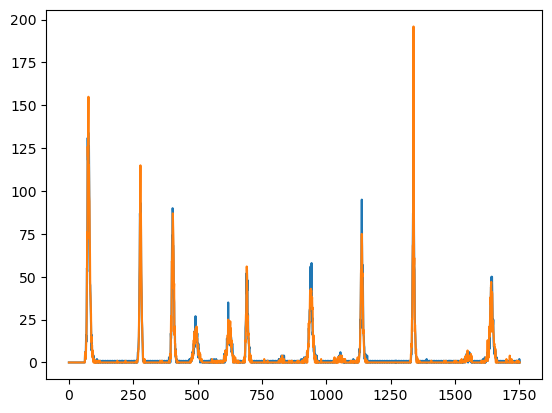

In [31]:
Cc = result.Cc
Csc = result.Csc
print(sum(Cc))
print(len(Cc))
Cc = np.add.reduceat(Cc, np.arange(0, len(Cc), 24)).tolist()
print(len(Cc))
Csc = np.add.reduceat(Csc, np.arange(0, len(Csc), 24)).tolist()
plt.plot(Cc,'-')
plt.plot(Csc,'-')
sum(result.Ic)

In [ ]:
# Calculate the effective R0 as beta * average contacts per hour per person * average time infectious

0.01 * np.mean(result.n_edges)/result.S[0] * ((48+96)/2 + (72+168)/2)

In [ ]:
plt.plot(result.n_edges)

In [ ]:
plt.plot(result.n_edges)

# Main analysis

Run simulations that gradually decrease number of nonhousehold contacts required for priority access. Start at 30
and work down. Begin by assuming no asymptomatic transmission and 70% symptomatic rate, no isolation.


Run 10 simulations for each, and chart the number of deaths.

4 vaccine priorities: 
- No vax
- Equal priority vax
- Age priority
- Contact priority

4 transmission scenarios: 
- With all of the above
- With all of the above + prior immunity
- No isolation, no pre/asymptomatic transmission, no NPIs, no prior immunity

# Q1: Comparing strategies

In [ ]:
q1_df = pd.read_csv("q1_df.csv", index_col = 0)

In [ ]:
q1_d = [x.index[x == x.min()].values.tolist() for i, x in q1_df.filter(like="_d").iterrows()]
q1_d = [item for sublist in q1_d for item in sublist]

print(collections.Counter(q1_d))

q1_r = [x.index[x == x.min()].values.tolist() for i, x in q1_df.filter(like="_r").iterrows()]
q1_r = [item for sublist in q1_r for item in sublist]

print(collections.Counter(q1_r))

# Q2: What it index cases come after vaccines have been distributed?

In [ ]:
q2_df = pd.read_csv("q2_df.csv", index_col=0)
# For each sim, figure out which strategy had lowest death and infection rates

q2_d = [x.index[x == x.min()].values.tolist() for i, x in q2_df.filter(like="_d").iterrows()]
q2_d = [item for sublist in q2_d for item in sublist]

print(collections.Counter(q2_d))

q2_r = [x.index[x == x.min()].values.tolist() for i, x in q2_df.filter(like="_r").iterrows()]
q2_r = [item for sublist in q2_r for item in sublist]

print(collections.Counter(q2_r))


# Q3: Finding the top % of num_cc to vaccinate

In [ ]:
q3_df = pd.read_csv("q3_df.csv", index_col = 0)
col = q3_df.pop("general_d")
q3_df.insert(q3_df.shape[1], "0_d", col)
col = q3_df.pop("general_r")
q3_df.insert(q3_df.shape[1], "0_r", col)
q3_df

In [ ]:
q3_d = q3_df.filter(like="_d")
q3_r = q3_df.filter(like="r")
x = [re.split("_",x) for x in q3_d.columns]
x = [int(y[0]) for y in x]
print(x)

In [ ]:
fix, ax = plt.subplots(2, figsize= (10,10))

ax[0].plot(x, q3_d.quantile(.5)*100, color = "red", label="Median")
ax[0].plot(x, q3_d.quantile(.25)*100, color = "black", label = "50% of simulations")
ax[0].plot(x, q3_d.quantile(.75)*100, color = "black")
ax[0].plot(x, q3_d.quantile(.05)*100, color = "grey", label = "90% of simulations")
ax[0].plot(x, q3_d.quantile(.95)*100, color = "grey")
ax[0].set_title("Deaths (% of Population)")
ax[0].set(xlabel="Vaccine Eligibility Threshold Number of Non-Household Contacts", ylabel="%")
ax[0].legend(loc='center left', bbox_to_anchor=(1, -.1))

ax[1].plot(x, q3_r.quantile(.5) *100, color = "red")
ax[1].plot(x, q3_r.quantile(.25)*100, color = "black")
ax[1].plot(x, q3_r.quantile(.75)*100, color = "black")
ax[1].plot(x, q3_r.quantile(.05)*100, color = "grey")
ax[1].plot(x, q3_r.quantile(.95)*100, color = "grey")
ax[1].set_title("Infections (% of Population)")
ax[1].set(xlabel="Vaccine Eligibility Threshold Number of Non-Household Contacts", ylabel="%")

plt.savefig("figs/cc_threshhold.png",bbox_inches='tight')

# Sensitivity tests

beta: 0.0001 to 0.1

rho (probability of clinical): 0 to 1

alpha (relative infectiousness of pre and asymptomatic): 0 to 1

isolation multiplier: 0 to 1

In [ ]:
# beta vec with no asymptomatic transmission
beta_vec = np.arange(0.001, 0.1 , 0.001)
beta_vec = beta_vec.repeat(10)

t = time.time()


def multi_fn(beta):
    """ Wrapper function for multiprocessing
    
    """
    
    result = BICS_ABM(
        ALPHA = 0,
        RHO = 1,
        N_HH = 1000, BETA = beta, 
        silent = True, 
        N_VAX_DAILY = 0
    )
    
    return (result.R[-1] / (result.S[0] + result.E[0]), result.D[-1] / (result.S[0] + result.E[0]))
    
    
result_vec = Parallel(n_jobs=8, verbose = 10)(delayed(multi_fn)(v) for v in beta_vec)
    
    
t = time.time() - t

print(len(beta_vec), "iterations took", t, "seconds")



In [ ]:


fig, ax = plt.subplots(2)
ax[0].scatter(beta_vec, [x[0] for x in result_vec])
ax[1].scatter(beta_vec, [x[1] for x in result_vec])

# Jointly vary the isolation multiplier and the proportion of symptomatic cases

In [ ]:
isomult_vec = np.arange(0, 1, 0.1)
rho_vec = np.arange(0, 1, 0.1)
isomult_vec, rho_vec = np.meshgrid(isomult_vec, rho_vec)
isomult_vec = isomult_vec.flatten().repeat(10)
rho_vec = rho_vec.flatten().repeat(10)


t = time.time()


def multi_fn(i, r):
    """ Wrapper function for multiprocessing
    
    """
    
    result = BICS_ABM(
        RHO = r,
        ISOLATION_MULTIPLIER = i, 
        N_HH = 1000, BETA = 0.01, 
        silent = True, 
        N_VAX_DAILY = 0
    )
    
    return (result.R[-1] / (result.S[0] + result.E[0]), result.D[-1] / (result.S[0] + result.E[0]))
    
    
result_vec = Parallel(n_jobs=8, verbose = 10)(delayed(multi_fn)(*x) for x in zip(isomult_vec, rho_vec))
    
    
t = time.time() - t

print(len(result_vec), "iterations took", t, "seconds")



In [ ]:
dv = np.array([x[0] for x in result_vec]).reshape((10,10,10))
iv = np.array([x[1] for x in result_vec]).reshape((10,10,10))

In [ ]:
plt.imshow(iv, extent = [0,1,0,1])
plt.title("% Of population infected")
plt.xlabel("Isolation Multiplier")
plt.ylabel("Proportion of cases that are clinical")
plt.show()

In [ ]:
plt.imshow(dv, extent = [0,1,0,1])
plt.title("% Of population dead")
plt.xlabel("Isolation Multiplier")
plt.ylabel("Proportion of cases that are clinical")
plt.show()

# Speed test

Not whole necessary, but kind of fun. Seems like there is no benefit past 4 or 8 threads.


In [ ]:
if True:
    reps = np.arange(1, 128, 1)



    def multi_fn(i):
        """ Wrapper function for multiprocessing

        """

        result = BICS_ABM(
            N_HH = 1000, 
            silent = True, 
        )

        return 0


    tlist = list()
    jlist = [4, 8, 16, 32, 64, 128]
    for jobs in jlist:
        t = time.time()
        Parallel(n_jobs=jobs, verbose = 10, prefer="threads")(delayed(multi_fn)(v) for v in reps)
        t = time.time() - t
        tlist.append(t)

    plt.scatter(jlist, tlist)